In [1]:
%matplotlib inline

import math
import time
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from datetime import date, datetime, time, timedelta
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

print(tf.__version__)

2.9.2


In [2]:
# Colab에서 kaggle 다운로드, kaggle API 업로드
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"eddkang","key":"1a6f4a96f9210e5ef549467b5c2971d4"}'}

In [ ]:
# ls -1ha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Persmisson Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

# kaggle에서 다운로드
!kaggle datasets download -d artemburenok/sp-500-stock-prices

# zip으로 압축되어 있는지 확인하고, 압축 해제
!ls
!unzip sp-500-stock-prices.zip

In [25]:
def get_mape(a, b):
    a, b = np.array(a), np.array(b)
    return np.mean(np.abs((a - b) / a)) * 100

def get_mae(a, b):
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_last_val(data, H):
    return np.array([data[-1]]*H)

In [29]:
column_names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
raw_dataset = pd.read_csv('/content/AAPL.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
# dataset, 위에서 부터 5개의 행 출력
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,Date,Open,High,Low,Close,Adj Close,Volume
1,1980-12-12,0.1283479928970337,0.1289059966802597,0.1283479928970337,0.1283479928970337,0.09987378865480423,469033600.0
2,1980-12-15,0.12221000343561172,0.12221000343561172,0.12165199965238571,0.12165199965238571,0.09466331452131271,175884800.0
3,1980-12-16,0.1132809966802597,0.1132809966802597,0.11272300034761429,0.11272300034761429,0.0877152606844902,105728000.0
4,1980-12-17,0.11551299691200256,0.11607100069522858,0.11551299691200256,0.11551299691200256,0.08988628536462784,86441600.0


In [30]:
# index 0이 사실상 쓸모없는 값이라 제거
dataset = dataset.drop(0)
dataset.head()

# Object 타입을 실수형으로 변경
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Open'] = np.array(dataset['Open'], dtype='float64')
dataset['High'] = np.array(dataset['High'], dtype='float64')
dataset['Low'] = np.array(dataset['Low'], dtype='float64')
dataset['Close'] = np.array(dataset['Close'], dtype='float64')
dataset['Adj Close'] = np.array(dataset['Adj Close'], dtype='float64')
# dataset['Volume'] = np.array(dataset['Volume'], dtype='int64')

dataset.sort_values(by='Date', inplace=True, ascending=True)

In [22]:
# NULL 값 제거 
dataset.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1980-12-12 00:00:00 2022-12-13 00:00:00


Text(0, 0.5, 'USD')

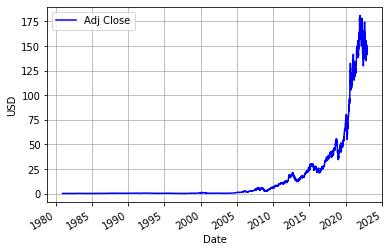

In [31]:
# Date 범위 확인
print(dataset['Date'].min(), dataset['Date'].max())
      
# 그래프로 확인
ax = dataset.plot(x='Date', y='Adj Close', style='b-' ,grid=True)
ax.set_xlabel('Date')
ax.set_ylabel('USD')

In [32]:
# 장 종료까지 포함해서 계산하기 위해 Adj Close를 사용할 것임.
dataset.pop("Close")
dataset.describe()

,Open,High,Low,Adj Close
count,10591.000000,10591.000000,10591.000000,10591.000000
mean,16.336541,16.522291,16.153177,15.673414
std,34.927120,35.350481,34.516790,34.618906
min,0.049665,0.049665,0.049107,0.038213
25%,0.286719,0.293828,0.280134,0.237255
50%,0.484375,0.493304,0.477679,0.402199
75%,16.014107,16.186429,15.804464,13.836675
max,182.630005,182.940002,179.119995,180.959747


In [33]:
# dataset을 test set과 training set으로 분리
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)